In [433]:
import tensorflow as tf
from keras.backend import clear_session
from keras.models import model_from_json
import time
import numpy as np
from sklearn.metrics import confusion_matrix, f1_score
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from basic_pitch.inference import predict
from basic_pitch import ICASSP_2022_MODEL_PATH
import os
from glob import glob
from tqdm import tqdm
import pickle
from keras.utils import np_utils
from python_play.player import play_it
from keras.models import Model, load_model
from keras.layers import Input, LSTM, Dropout, Flatten, Dense, Activation
from keras.callbacks import ModelCheckpoint
from music21 import converter, instrument, note, chord, stream


## Data Preprocessing

In [434]:
def create_midi_from_wav_basic_pitch(wav_file_path: str, midi_file_path: str):
    model_output, midi_data, note_events = predict(wav_file_path, ICASSP_2022_MODEL_PATH)
    midi_data.write(midi_file_path)

In [435]:
if os.path.exists('dataset_midi'):
    pass
else:
    classes = []
    os.mkdir('dataset_midi')
    for i in os.listdir('dataset_wav'):
        classes.append(i)
        os.mkdir('dataset_midi/'+i)

    for i in classes:
        for j in os.listdir('dataset_wav/'+i):
            wav_file_path = 'dataset_wav/'+i+'/'+j
            midi_file_path = 'dataset_midi/'+i+'/'+j[:-4]+'.mid'
            create_midi_from_wav_basic_pitch(wav_file_path, midi_file_path)
            print(f"MIDI file created successfully: {midi_file_path}")

## Music Generation

In [436]:
def get_notes(mood):
    notes = []
    songs = glob(os.path.join('dataset_midi',mood, '**', '*.mid'), recursive=True)
    print (f"{len(songs)} MIDI files found in {mood} folder")
    
    for file in songs:
        try:
            # converting .mid file to stream object
            midi = converter.parse(file)
            
            # Given a single stream, partition into a part for each unique instrument
            parts = instrument.partitionByInstrument(midi)
            
            if parts and len(parts.parts) > 1:  # Check if parts has at least two elements
                notes_to_parse = parts.parts[1].recurse()
            else:
                notes_to_parse = midi.flat.notes

            for element in notes_to_parse: 
                if isinstance(element, note.Note):
                    # if element is a note, extract pitch
                    print(element.pitch)
                    notes.append(str(element.pitch))
                elif isinstance(element, chord.Chord):
                    # if element is a chord, append the normal form of the 
                    # chord (a list of integers) to the list of notes.
                    print(element.normalOrder) 
                    notes.append('.'.join(str(n) for n in element.normalOrder))
        except Exception as e:
            print(f"Error processing {file}: {e}")
    if not os.path.exists(f'Notes'):
        os.makedirs(f'Notes')
    with open(f'Notes/notes_{mood}', 'wb') as filepath:
        pickle.dump(notes, filepath)

    return notes

In [437]:
def prepare_sequences(notes, n_vocab): 
    if not notes:
        print("Error: Input 'notes' list is empty.")
        return [], []
    
    sequence_length = 50

    # Extract the unique pitches in the list of notes.
    pitchnames = sorted(set(item for item in notes))

    # Create a dictionary to map pitches to integers
    note_to_int = dict((note, number) for number, note in enumerate(pitchnames))

    network_input = []
    network_output = []

    # create input sequences and the corresponding outputs
    for i in range(0, len(notes) - sequence_length, 1):
        sequence_in = notes[i: i + sequence_length]
        sequence_out = notes[i + sequence_length]
        network_input.append([note_to_int[char] for char in sequence_in])
        network_output.append(note_to_int[sequence_out])
    print(network_input)
    print(network_output)

    
    n_patterns = len(network_input)
    
    # reshape the input into a format comatible with LSTM layers 
    network_input = np.reshape(network_input, (n_patterns, sequence_length, 1))
    
    # normalize input
    network_input = network_input / float(n_vocab)
    
    # one hot encode the output vectors
    network_output = np_utils.to_categorical(network_output)
    
    return (network_input, network_output)

In [438]:
class DynamicInputModel(Model):
    def __init__(self,n_vocab):
        super(DynamicInputModel, self).__init__()
        self.n_vocab = n_vocab
        #define layers
        self.lstm_1 = LSTM(128, return_sequences=True)
        self.dropout_1 = Dropout(0.2)
        self.lstm_2 = LSTM(128, return_sequences=True)
        self.flatten = Flatten()
        self.dense_1 = Dense(256)
        self.dropout_2 = Dropout(0.3)
        self.output_layer = Dense(self.n_vocab, activation='softmax')

    def call(self, inputs):
        x = self.lstm_1(inputs)
        x = self.dropout_1(x)
        x = self.lstm_2(x)
        x = self.flatten(x)
        x = self.dense_1(x)
        x = self.dropout_2(x)
        output = self.output_layer(x)
        return output

    def build_model(self,mood):
        network_input, _ = prepare_sequences(get_notes(mood), self.n_vocab)
        inputs = Input(shape=network_input.shape[1:])
        outputs = self.call(inputs)
        self.model = Model(inputs, outputs)
        self.model.compile(loss='categorical_crossentropy', optimizer='adam')
        self.model.summary()
    
    def train(self,network_input, network_output, epochs, batch_size, n_vocab):
        filepath = f'weights.best.music_50_{n_vocab}.hdf5'
        checkpoint = ModelCheckpoint(
            filepath,
            monitor='loss',
            verbose=0,
            save_best_only=True,
            mode='min'
        )
        callbacks_list = [checkpoint]
        self.model.fit(network_input, network_output, epochs=epochs, batch_size=batch_size, callbacks=callbacks_list)

    def save_model(self):
        self.model.save(f'model_50_{self.n_vocab}.h5')

In [439]:
def train_network(mood):
    epochs = 200
    batch_size = 128
    notes = get_notes(mood)
    n_vocab = len(set(notes))
    network_in, network_out = prepare_sequences(notes, n_vocab)

    model = DynamicInputModel(n_vocab=n_vocab)
    model.build_model(mood)
    model.train(network_in, network_out, epochs, batch_size,n_vocab)
    model.save_model()

    if not os.path.exists(f'Notes'):
        os.makedirs(f'Notes')
    with open(f'Notes/notes_{mood}', 'wb') as filepath:
        pickle.dump(notes, filepath)

In [440]:
def create_midi(prediction_output,mood):
    """ convert the output from the prediction to notes and create a midi file
        from the notes """
    offset = 0
    output_notes = []

    # create note and chord objects based on the values generated by the model
    for pattern in prediction_output:
        # pattern is a chord
        if ('.' in pattern) or pattern.isdigit():
            notes_in_chord = pattern.split('.')
            notes = []
            for current_note in notes_in_chord:
                new_note = note.Note(int(current_note))
                new_note.storedInstrument = instrument.Piano()
                notes.append(new_note)
            new_chord = chord.Chord(notes)
            new_chord.offset = offset
            output_notes.append(new_chord)
        # pattern is a note
        else:
            new_note = note.Note(pattern)
            new_note.offset = offset
            new_note.storedInstrument = instrument.Piano()
            output_notes.append(new_note)

        # increase offset each iteration so that notes do not stack
        offset += 0.5

    midi_stream = stream.Stream(output_notes)
    
    print('Saving Output file as midi....')
    n = 1
    #create a folder if it doesnt exist for each test_output file by their mood and save the midi file there indicated by a specific number
    if not os.path.exists(f'Generated_Audio/{mood}'):
        os.makedirs(f'Generated_Audio/{mood}')
    #get the value of n for the test_output file
    for i in os.listdir(f'Generated_Audio/{mood}'):
        n += 1
    #save the midi file in the folder with the name of the mood and numbered by the number of the test_output file
    midi_stream.write('midi', fp=f'Generated_Audio/{mood}/result_audio_{n}.mid')

In [441]:
def generate_seed_pattern(network_input):
    # Generate a unique seed pattern as the starting point for music generation
    start = np.random.choice(range(len(network_input)))
    seed_pattern = network_input[start]
    return seed_pattern

def generate_notes(model, network_input, pitchnames,n_vocab,temperature=0.5):
    #if the model is model_50_298.h5 then always make sure the seed pattern is selected from the last 100 values of the network_input
    if model.name == 'model_50_298.h5':
        seed_pattern = generate_seed_pattern(network_input[-400:])
    elif model.name == 'model_50_376.h5':
        seed_pattern = generate_seed_pattern(network_input[-400:])
    else:
        seed_pattern = generate_seed_pattern(network_input)
        int_to_note = dict((number, note) for number, note in enumerate(pitchnames))
        pattern = seed_pattern
        print ('pattern.shape', pattern.shape)
        prediction_output = []

        print('Generating notes........')

    for note_index in range(500):
        # Correct the dimensions of the pattern array to match the input required by the model
        prediction_input = np.reshape(pattern, (1, len(pattern), 1))
        prediction_input = prediction_input / float(n_vocab)

        # prediction = model.predict(prediction_input, verbose=0)
        prediction = model.predict(prediction_input, verbose=0)[0]
        scaled_prediction = np.log(prediction) / temperature
        exp_prediction = np.exp(scaled_prediction)
        normalized_prediction = exp_prediction / np.sum(exp_prediction)
        index = np.random.choice(range(len(normalized_prediction)), p=normalized_prediction)

        # Mapping the predicted interger back to the corresponding note
        result = int_to_note[index]
        # Storing the predicted output
        prediction_output.append(result)

        pattern = np.append(pattern, index)
        #Next input to the model will be current input pattern minus the first value and plus the predicted output
        pattern = pattern[1:len(pattern)]

    #use the last 250 values of predicted output
    prediction_output = prediction_output[250:len(prediction_output)]
    print('Notes Generated...')
    return prediction_output

def load_model_and_weights(model_path, weights_path):
    model = load_model(model_path)
    model.load_weights(weights_path)
    model.compile(loss='categorical_crossentropy', optimizer='adam')
    return model

def generate(mood):
    
    def plot_pitch_histogram(notes, title):
        # Extract pitches from notes
        pitches = [note.split('.')[0] for note in notes if '.' in note]

        # Create a histogram
        plt.hist(pitches, bins=range(1, len(set(pitches)) + 2), alpha=0.5, label='Pitches')
        plt.title(title)
        plt.xlabel('Pitch')
        plt.ylabel('Frequency')
        plt.legend()
        plt.show()

    def jaccard_similarity(set1, set2):
        intersection = len(set1.intersection(set2))
        union = len(set1.union(set2))
        return intersection / union if union != 0 else 0

    def plot_note_length_histogram(notes, title):
        note_lengths = [float(note.split('.')[-1]) for note in notes if '.' in note]

        plt.hist(note_lengths, bins=range(1, int(max(note_lengths)) + 2), alpha=0.5, label='Note Lengths')
        plt.title(title)
        plt.xlabel('Note Length')
        plt.ylabel('Frequency')
        plt.legend()
        plt.show()

    def plot_confusion_matrix(y_true, y_pred, labels, title):
        cm = confusion_matrix(y_true, y_pred, labels=labels)
        plt.figure(figsize=(len(labels), len(labels)))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
        plt.title(title)
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.show()

    def calculate_f1_score(y_true, y_pred, average='weighted'):
        return f1_score(y_true, y_pred, average=average)

    def classify_notes_by_length(note_lengths, threshold=0.5):
        return ['Short' if length <= threshold else 'Long' for length in note_lengths]

    def evaluate_model(generated_notes,notes):
        
        #visual representation of the pitch and chord distributions
        plot_pitch_histogram(notes, 'Original Pitch Distribution')
        plot_pitch_histogram(generated_notes, 'Generated Pitch Distribution')

        # Jaccard similarity between the sets of unique pitches or chords
        original_pitch_set = set([note.split('.')[0] for note in notes if '.' in note])
        generated_pitch_set = set([note.split('.')[0] for note in generated_notes if '.' in note])

        pitch_similarity = jaccard_similarity(original_pitch_set, generated_pitch_set)
        print(f'Jaccard Similarity for Pitches: {pitch_similarity}')

        # Visual representation of the note length distributions
        plot_note_length_histogram(notes, 'Original Note Length Distribution')
        plot_note_length_histogram(generated_notes, 'Generated Note Length Distribution')

        #Plot F1 Score and Confusion Matrix
        original_note_lengths = [float(note.split('.')[-1]) for note in notes if '.' in note]
        generated_note_lengths = [float(note.split('.')[-1]) for note in generated_notes if '.' in note]

        # Define a threshold for classifying short and long notes (you can adjust this threshold)
        threshold = 0.5
        original_labels = classify_notes_by_length(original_note_lengths, threshold)
        generated_labels = classify_notes_by_length(generated_note_lengths, threshold)

        # Ensure both original_labels and generated_labels have the same length
        min_length = min(len(original_labels), len(generated_labels))
        original_labels = original_labels[:min_length]
        generated_labels = generated_labels[:min_length]

        # Plot confusion matrix
        plot_confusion_matrix(original_labels, generated_labels, labels=['Short', 'Long'], title='Note Length Confusion Matrix')

        # Calculate F1 score
        f1 = calculate_f1_score(original_labels, generated_labels)
        print(f'F1 Score: {f1}')


    with open(f'Notes/notes_{mood}', 'rb') as filepath:
        notes = pickle.load(filepath)

    # Get all pitch names
    pitchnames = sorted(set(item for item in notes))
    # Get all pitch names
    n_vocab = len(set(notes))

    network_input,_= prepare_sequences(notes, n_vocab)

    print('Initiating music generation process.......')
    
    network_input = get_inputSequences(notes, pitchnames, n_vocab)

    # Load model architecture and weights separately
    model_path = f'model_50_{n_vocab}.h5'
    weights_path = f'weights.best.music_50_{n_vocab}.hdf5'

    model = DynamicInputModel(n_vocab=n_vocab)

    model = load_model_and_weights(model_path, weights_path)

    print("\nModel Summary After Loading Weights:")
    model.summary()

    prediction_output = generate_notes(model, network_input, pitchnames, n_vocab,temperature=1.0)
    create_midi(prediction_output,mood)
    
    evaluate_model(prediction_output,notes)

def get_inputSequences(notes, pitchnames, n_vocab): 
    """ Prepare the sequences used by the Neural Network """
    # map between notes and integers and back
    note_to_int = dict((note, number) for number, note in enumerate(pitchnames))

    sequence_length = 50
    network_input = []
    for i in range(0, len(notes) - sequence_length, 1):
        sequence_in = notes[i:i + sequence_length]
        network_input.append([note_to_int[char] for char in sequence_in])

    n_patterns = len(network_input)
    print ('n_patterns ', n_patterns)
    print ('n_vocab ', n_vocab)
    
    # reshape the input into a format comatible with LSTM layers 
    network_input = np.reshape(network_input, (n_patterns, sequence_length, 1))
    
    # normalize input
    network_input = network_input / float(n_vocab)

    return (network_input)

## Mood Classification

In [442]:
# Load the pre-trained emotion classification model
from transformers import pipeline
emotion = pipeline('sentiment-analysis', 
                    model='arpanghoshal/EmoRoBERTa')

All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

All the layers of TFRobertaForSequenceClassification were initialized from the model checkpoint at arpanghoshal/EmoRoBERTa.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaForSequenceClassification for predictions without further training.


In [443]:
def map_emotion_to_mood(emotion_label):
    emotion_to_mood_mapping = {
        "grief": "Sad",
        "sadness": "Sad",
        "disappointment": "Sad",
        "remorse": "Sad",
        "disapproval": "Sad",
        "annoyance": "Sad",
        "anger": "Aggressive",
        "disgust": "Aggressive",
        "embarrassment": "Sad",
        "fear": "Aggressive",
        "nervousness": "Aggressive",
        "amusement": "Happy",
        "joy": "Happy",
        "love": "Romantic",
        "admiration": "Happy",
        "approval": "Happy",
        "caring": "Romantic",
        "curiosity": "Happy",
        "desire": "Happy",
        "excitement": "Happy",
        "gratitude": "Happy",
        "optimism": "Happy",
        "surprise": "Dramatic",
        "realization": "Dramatic",
        "pride": "Dramatic",
        "relief": "Dramatic",
        "confusion": "Sad",
        "neutral": "Happy",
    }

    # Map the emotion label to your desired mood
    mapped_mood = emotion_to_mood_mapping.get(emotion_label, "Unknown")

    return mapped_mood  

## User Input

[[268, 19, 282, 118, 280, 118, 280, 118, 281, 282, 280, 21, 280, 268, 281, 268, 268, 268, 280, 281, 268, 268, 280, 268, 281, 118, 280, 268, 280, 118, 118, 268, 268, 282, 268, 282, 268, 268, 268, 282, 268, 268, 280, 118, 268, 268, 280, 118, 268, 268], [19, 282, 118, 280, 118, 280, 118, 281, 282, 280, 21, 280, 268, 281, 268, 268, 268, 280, 281, 268, 268, 280, 268, 281, 118, 280, 268, 280, 118, 118, 268, 268, 282, 268, 282, 268, 268, 268, 282, 268, 268, 280, 118, 268, 268, 280, 118, 268, 268, 282], [282, 118, 280, 118, 280, 118, 281, 282, 280, 21, 280, 268, 281, 268, 268, 268, 280, 281, 268, 268, 280, 268, 281, 118, 280, 268, 280, 118, 118, 268, 268, 282, 268, 282, 268, 268, 268, 282, 268, 268, 280, 118, 268, 268, 280, 118, 268, 268, 282, 280], [118, 280, 118, 280, 118, 281, 282, 280, 21, 280, 268, 281, 268, 268, 268, 280, 281, 268, 268, 280, 268, 281, 118, 280, 268, 280, 118, 118, 268, 268, 282, 268, 282, 268, 268, 268, 282, 268, 268, 280, 118, 268, 268, 280, 118, 268, 268, 282, 280, 118

c:\ProgramData\anaconda3\envs\tf\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: divide by zero encountered in log


Notes Generated...
Saving Output file as midi....


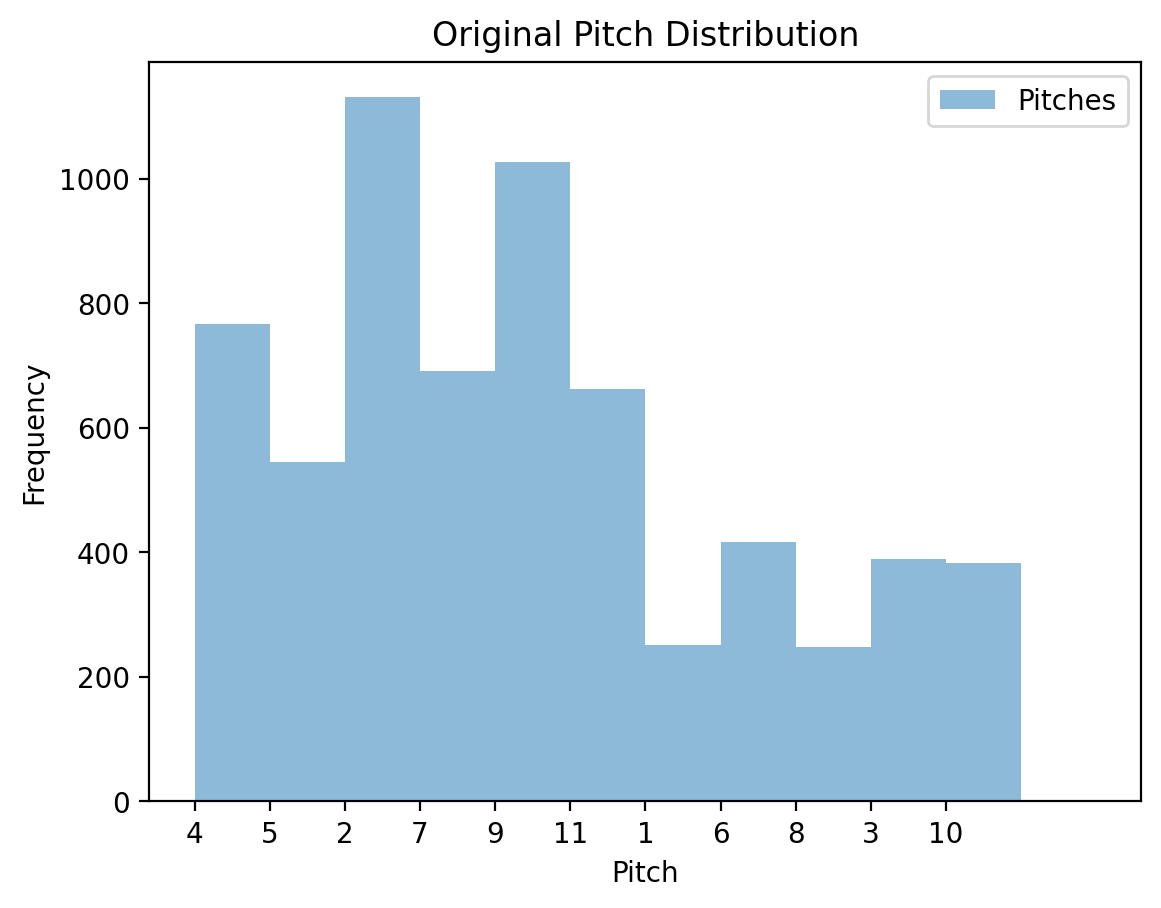

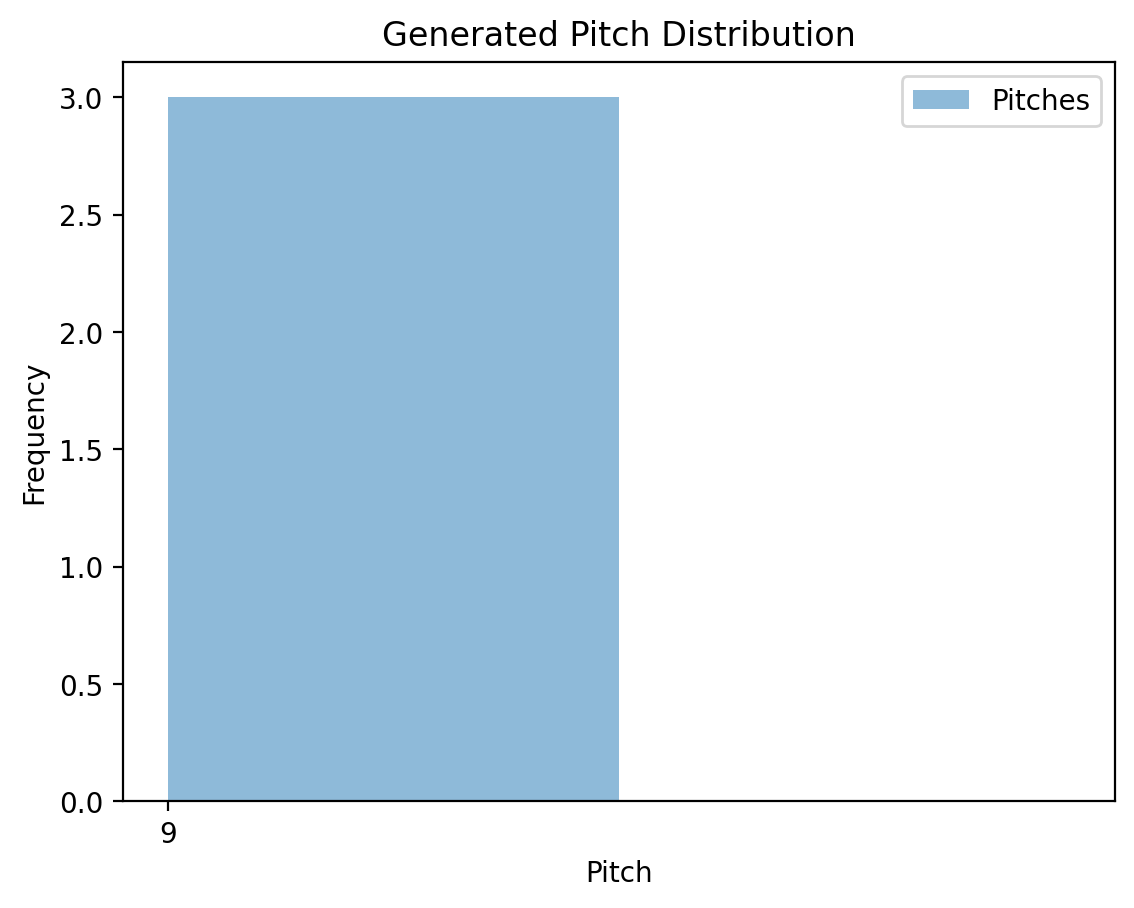

Jaccard Similarity for Pitches: 0.16666666666666666


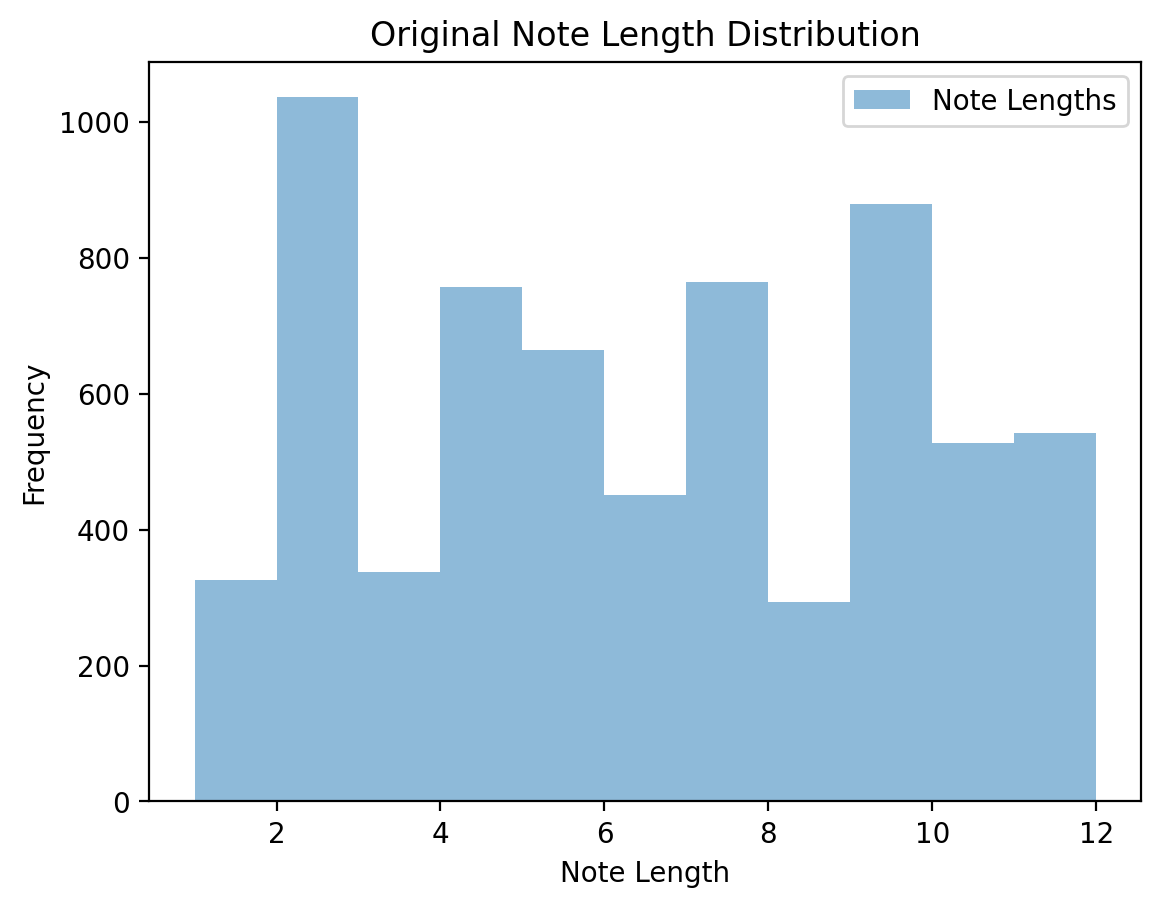

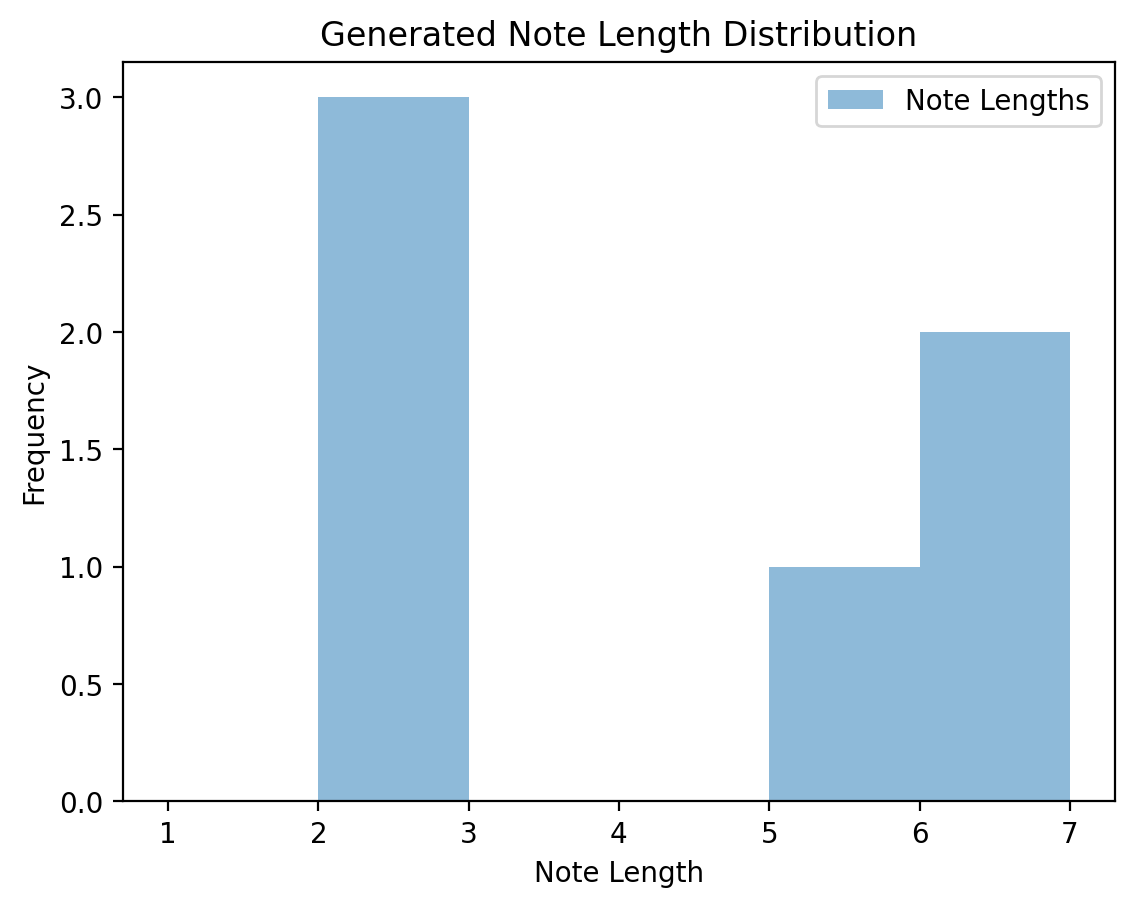

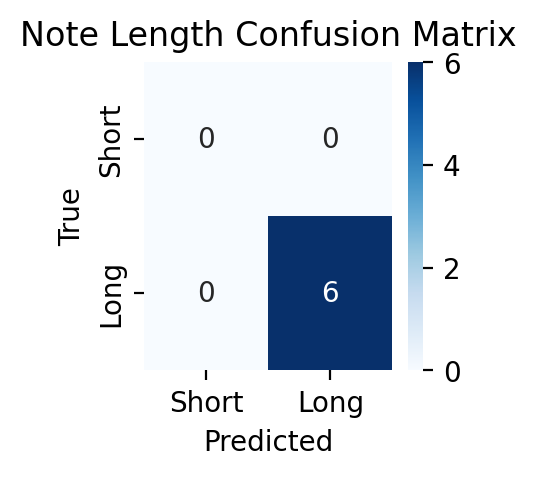

F1 Score: 1.0


In [444]:
def main():    
    #Train the model for every mood in a loop
    # for mood in ['Aggressive', 'Dramatic', 'Happy', 'Romantic', 'Sad']:
    #     train_network(mood)

    choice = int(input("Enter your choice[ (1). Generate music using your own text |||| (2). Generate music using predefined moods:"))

    #if the user wants to generate music using their own text then ask them to enter their text
    if choice == 1:
        user_text = input("Tell us what are you feeling right now, your thoughts, your emotions and we shall generate music for you:")

        emotion_labels = emotion(user_text)[0]['label']

        print("-"*50)
        
        #print predicted emotion and its score
        print(f"Predicted Emotion: {emotion_labels}", f"Confidence: {emotion(user_text)[0]['score']}")
        #map the predicted emotion to a mood
        mapped_mood = map_emotion_to_mood(emotion_labels)
        print(f"Mapped Mood: {mapped_mood}")
        #generate music for the mapped mood
        generate(mapped_mood)

    if choice == 2:
        #if the user wants to generate music using predefined moods then ask them to select the mood
        mood = input("Enter the mood for which you want to generate music [Aggressive,Dramatic,Happy,Romantic,Sad]:")
        generate(mood)        

if __name__ == "__main__":
    main()  